# Camera calibration
In order to estimate markers' pose first we need to find the <b>camera matrix</b> and the <b>distortion coefficients</b>. Both are intrinsic camera parameters, so calibration has to be performed only once.

sources:<br>
https://it.mathworks.com/help/vision/ug/camera-calibration.html <br>
https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

## Setup

In [0]:
!git clone https://github.com/Nunzio03/follow-me-drone-notebooks

In [5]:

%cd follow-me-drone-notebooks/
!pip3 install -r requirements.txt


/content/follow-me-drone-notebooks


## ArUco Chessboard generation

In [6]:
import numpy as np
import cv2, PIL
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from IPython.display import display, Math
print("import completed")

import completed


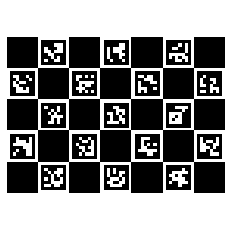

In [7]:

workdir = "./markers/"
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imwrite(workdir + "chessboard.png", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()

## Calibration
After printing the charuco board we need to take several pictures of the board with the camera that we want to calibrate

In [8]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
import matplotlib.pyplot as plt

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
datadir = "./drone calibration photos/"

images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".png") ])


def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTED...")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        # print("=> Processing image {0}".format(im))
        print('.', end="")
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

allCorners,allIds,imsize=read_chessboards(images)


def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    #flags = (cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors


ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
print("\n CALIBRATION COMPLETED")


POSE ESTIMATION STARTED...
.....................
 CALIBRATION COMPLETED


## Results
Now we can store these results, and use them for ArUco identification and pose estimation

In [9]:
display(Math('Camera \hspace{1mm} matrix:'))
display(Math(r'\begin{bmatrix}'+f'{mtx[0][0]} & {mtx[0][1]} & {mtx[0][2]}' +r' \\' +
            f'{mtx[1][0]} & {mtx[1][1]} & {mtx[1][2]}' +r' \\' +
             f'{mtx[2][0]} & {mtx[2][1]} & {mtx[2][2]}' +r' \\' + r'\end{bmatrix}'))

display(Math('Distortion \hspace{1mm} coefficients \hspace{1mm} vector:'))
display(Math(r'\begin{bmatrix}'+ f'{dist[0][0]} ' +r' \\' +
                                 f'{dist[1][0]} ' +r' \\' +
                                 f'{dist[2][0]} ' +r' \\' +
                                 f'{dist[3][0]} ' +r' \\' +
                                 f'{dist[4][0]} ' +r' \\' +
                                 f'{dist[5][0]} ' +r' \\' +
                                 f'{dist[6][0]} ' +r' \\' +
                                 f'{dist[7][0]} ' +r' \\' +
                                 f'{dist[8][0]} ' +r' \\' +
                                 f'{dist[9][0]} ' +r' \\' +
                                 f'{dist[10][0]} ' +r' \\' +
                                 f'{dist[11][0]} ' +r' \\' +
                                 f'{dist[12][0]} ' +r' \\' +
                                 f'{dist[13][0]} ' +r' \\' +                                       
                                 r'\end{bmatrix}'))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>